In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

In [2]:
sns.set() # Activar módulo de seaborn

## Análisis de varianza para diseños con un factor y con bloques

A continuación se presenta un ejemplo del uso de python como herramienta para realizar el análisis de varianza para un experimento con un solo factor y con un bloque. El experimento que se propone es:

* Se desea evaluar si existe diferencia en la medición de dureza de 4 puntas, adicionalmente, se sospecha que el tipo de material puede tener un efecto sobre las mediciones, por lo que se decide conformar 4 bloques. Los resultados después de hacer las pruebas de dureza se anexan en el archivo "Bloques"

## 1. Análisis descriptivo

Inicialmente se plantea el uso de gráficos y medidas de tendencia central y variación para hacer una primera interpretación de los datos observados. Se resalta una vez más la importancia de esta etapa en cualquier estudio estadístico

In [3]:
# Importar datos

df = pd.read_excel("Bloques.xlsx")
df.columns

Index(['Punta', 'Bloque', 'Dureza'], dtype='object')

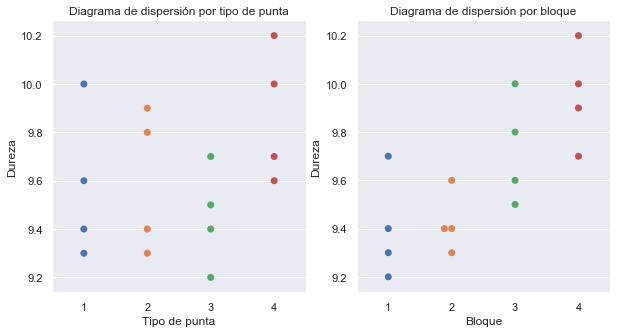

In [4]:
# Diagrama de dispersión por tipo de punta

plt.figure(figsize=(10,5))

plt.subplot(1,2,1) # (filas, columnas, número de paneles)
sns.swarmplot(x="Punta", y="Dureza", data=df, s=7)
plt.xlabel("Tipo de punta")
plt.title("Diagrama de dispersión por tipo de punta")

plt.subplot(1,2,2) # (filas, columnas, número de paneles)
sns.swarmplot(x="Bloque", y="Dureza", data=df, s=7)
plt.xlabel("Bloque")
plt.title("Diagrama de dispersión por bloque")
plt.show()


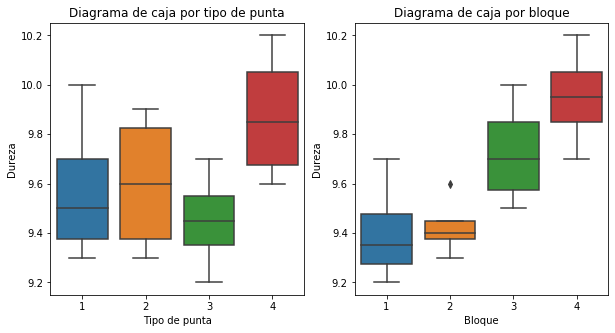

In [5]:
# Diagrama de cajas para la dureza

plt.figure(figsize=(10,5))

plt.subplot(1,2,1) # (filas, columnas, número de paneles)
sns.boxplot(x="Punta", y="Dureza", data=df)
plt.xlabel("Tipo de punta")
plt.title("Diagrama de caja por tipo de punta")

plt.subplot(1,2,2) # (filas, columnas, número de paneles)
sns.boxplot(x="Bloque", y="Dureza", data=df)
plt.xlabel("Bloque")
plt.title("Diagrama de caja por bloque")
plt.show()


In [6]:
# Se usa la función groupby para agrupar las observaciones por tipo de punta y describirlas

df.groupby(by="Punta").describe()

Bloque                                           Dureza         \
       count mean       std  min   25%  50%   75%  max  count   mean   
Punta                                                                  
1        4.0  2.5  1.290994  1.0  1.75  2.5  3.25  4.0    4.0  9.575   
2        4.0  2.5  1.290994  1.0  1.75  2.5  3.25  4.0    4.0  9.600   
3        4.0  2.5  1.290994  1.0  1.75  2.5  3.25  4.0    4.0  9.450   
4        4.0  2.5  1.290994  1.0  1.75  2.5  3.25  4.0    4.0  9.875   

                                                 
            std  min    25%   50%     75%   max  
Punta                                            
1      0.309570  9.3  9.375  9.50   9.700  10.0  
2      0.294392  9.3  9.375  9.60   9.825   9.9  
3      0.208167  9.2  9.350  9.45   9.550   9.7  
4      0.275379  9.6  9.675  9.85  10.050  10.2

## 2. Análisis de varianza

In [8]:
# Inicialmente se ajusta el modelo utilizando mínimos cuadrados

modelo = ols("Dureza ~ C(Punta) + C(Bloque)", data=df).fit()
anova = sm.stats.anova_lm(modelo, type=2)
print(anova)

            df  sum_sq   mean_sq        F    PR(>F)
C(Punta)   3.0   0.385  0.128333  14.4375  0.000871
C(Bloque)  3.0   0.825  0.275000  30.9375  0.000045
Residual   9.0   0.080  0.008889      NaN       NaN


Considerando el valor de F=14.43 y el valor p= 0.001, se puede indicar que existe evidencia significativa para afirmar que las medidas de dureza son diferentes según el tipo de punta utilizada. El interés ahora está en poder determinar cuales son las puntas que están siendo diferentes, pero antes se considera que hubiera pasado si no se consideraban los bloques

In [8]:
# Escenario 2, no se consideran bloques sino réplicas como en un diseño monofactorial

modelo_2 = ols("Dureza ~ C(Punta)", data=df).fit()
anova_2 = sm.stats.anova_lm(modelo_2, type=2)
print(anova_2)

            df  sum_sq   mean_sq         F    PR(>F)
C(Punta)   3.0   0.385  0.128333  1.701657  0.219568
Residual  12.0   0.905  0.075417       NaN       NaN


En este segundo escenario se puede evidenciar que no existe evidencia significativa para afirmar que las puntas son diferentes (valor p =0.21>0.05). Esta situación se presenta al ignorar la conformación de bloques, inflando así la variabilidad asociada al error (ver sumas cuadradas de los residuales)

## 3. Pruebas de supuestos

### a. Normalidad

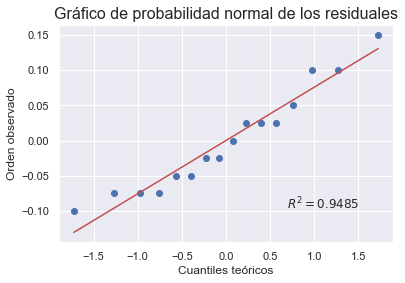

In [9]:
# Gráfico de probabilidad normal

normal_plot, stat = stats.probplot(modelo.resid, plot=plt, rvalue= True)

plt.title("Gráfico de probabilidad normal de los residuales", fontsize= 16)
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Orden observado")

plt.show()

In [10]:
SW = stats.shapiro(modelo.resid)
print(SW)

(0.9395751953125, 0.34384334087371826)


### b. Homocedasticidad

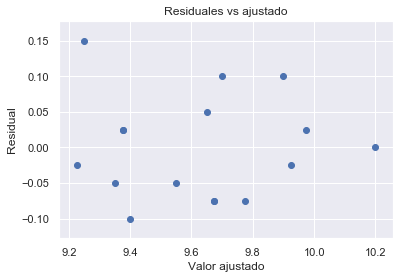

In [11]:
ajustado = modelo.predict()
residual = modelo.resid

plt.scatter(ajustado, residual)
plt.xlabel("Valor ajustado")
plt.ylabel("Residual")
plt.title("Residuales vs ajustado")
plt.show()

In [12]:
# Prueba de Levene para supuesto de homocedasticidad (en las puntas)

stats.levene(df['Dureza'][df['Punta'] == 1],
             df['Dureza'][df['Punta'] == 2], 
             df['Dureza'][df['Punta'] == 3],
             df['Dureza'][df['Punta'] == 4])

LeveneResult(statistic=0.48648648648648685, pvalue=0.6979963001965435)

In [13]:
# Prueba de Levene para supuesto de homocedasticidad (en los bloques)

stats.levene(df['Dureza'][df['Bloque'] == 1],
             df['Dureza'][df['Bloque'] == 2], 
             df['Dureza'][df['Bloque'] == 3],
             df['Dureza'][df['Bloque'] == 4])

LeveneResult(statistic=0.5806451612903311, pvalue=0.6388701228758145)

### c. Independencia

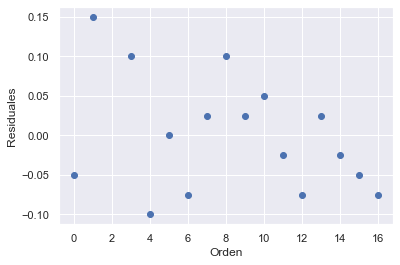

In [14]:
np.random.seed(5)

orden = random.sample(range(17),16)
plt.plot(orden, modelo.resid, marker=".", linestyle="none", markersize=12)
plt.xlabel("Orden")
plt.ylabel("Residuales")
plt.show()